Output(layout=Layout(border_bottom='1px solid black', border_left='1px solid black', border_right='1px solid b…

interactive(children=(FloatSlider(value=0.9, description='zoom', max=1.0, min=0.05, step=0.05), Button(descrip…

User input [a,b,c,apl,bet,gam,SG]= 4.2 4.2 4.2 90.0 90.0 90.0 221

 Recalculating diffraction rings for new lattice..


 Updating plot with new geometry..




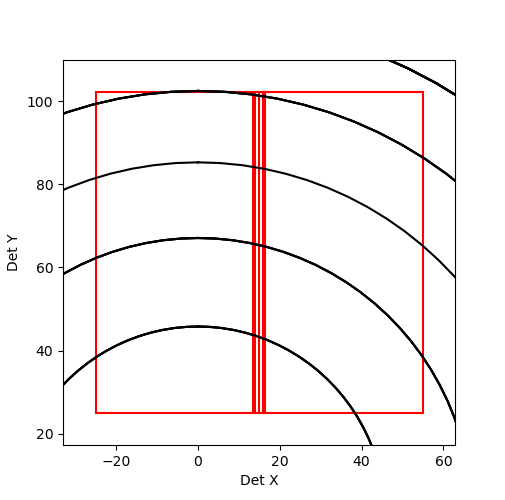

In [10]:
import numpy as np
import h5py, hdf5plugin, os, glob, time, math
import matplotlib, matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from ipywidgets import interact, interact_manual
import ipywidgets as widgets
import mpxrd_libraries_v4 as mpxrd_lib
from pymatgen.io.cif import CifParser
from pymatgen.analysis.diffraction import xrd

theta = np.linspace(0,2*np.pi,num=100)
xx = np.linspace(0,1,num=100)
yy = np.linspace(0,1,num=100)
detW = 79.9
detH = 77.2

# Input Widgets
output = widgets.Output()
wd = widgets.IntSlider(value=150, min=50, max=1000, step=1, description='Det dist (mm):', disabled=False, continuous_update=False, 
                       orientation='horizontal', readout=True, readout_format='d', tooltip = 'Sample to detector normal distance in mm')
wx = widgets.IntSlider(value=15, min=0, max=500, step=1, description='Det X-pos (mm):', disabled=False, continuous_update=False, 
                       orientation='horizontal', readout=True, readout_format='d', 
                       tooltip = 'Detector displcement in horizontal direction from beam position, in mm')
wy = widgets.IntSlider(value=25, min=0, max=500, step=1, description='Det Y-pos (mm):', disabled=False, continuous_update=False, 
                       orientation='horizontal', readout=True, readout_format='d',
                       tooltip = 'Detector displcement in vertical direction from beam position, in mm')

wa = widgets.FloatText(value=4.2, description='a (Å):', disabled=False, tooltip = 'Cell parameter a')
wb = widgets.FloatText(value=4.2, description='b (Å):', disabled=False, tooltip = 'Cell parameter b')
wc = widgets.FloatText(value=4.2, description='c (Å):', disabled=False, tooltip = 'Cell parameter c')
walp = widgets.FloatText(value=90, description='alpha (deg):', disabled=False, tooltip = 'Unit-cell angle alpha')
wbet = widgets.FloatText(value=90, description='beta (deg):', disabled=False, tooltip = 'Unit-cell angle beta')
wgam = widgets.FloatText(value=90, description='gamma (deg):', disabled=False, tooltip = 'Unit-cell angle gamma')
wE = widgets.BoundedIntText(value=10000, min = 5000, max = 40000, description='Energy (eV):', disabled=False, tooltip = 'Incoming beam energy (eV)')
wSG = widgets.Dropdown(options=mpxrd_lib.spaceGroups, value=221, description='Space Group:', tooltip='Choose space group')
wCIF = widgets.Text(value='/data/staff/balder/mahram/scripts/BN_hex.cif', placeholder='path to cif file', description='CIF File:', disabled=False)
wcbox = widgets.Checkbox(value=False, description='Check to use CIF File', disabled=False, indent=False)
det_box = widgets.VBox([wd, wx, wy])
abc_box = widgets.VBox([wa,wb,wc])
angle_box = widgets.VBox([walp,wbet,wgam])

inp_box_1 = widgets.HBox([det_box,abc_box,angle_box])
display(inp_box_1)
inp_box_2 = widgets.HBox([wE,wSG,wCIF,wcbox])
display(inp_box_2)

out = widgets.Output(layout={'border': '1px solid black'})
display(out)

xlim1 = -detW/2+wx.value
xlim2 = detW/2+wx.value
ylim2 = detH+wy.value
ylim1 = wy.value
# mpxrd_lib.drawBox(p1,-78.8-wy.value,-wy.value,-38.9-wx.value,38.9-wx.value)

wavelength = 12398.47/wE.value
    
darray = []
harray = []
karray = []
larray = []
intensityarray= []

def input_check(a,b,c,alp,bet,gam):
    messageText = 'Input error. Check lattice parameters!\n Monoclinic: beta!=90\n Hexagonal gamma=120'
    spgr = wSG.value
    #print(a,b,c,alp,bet,gam,spgr)
    checkValue = True
    out.layout={'border': '3px solid green'}
    if a==b==c and alp==bet==gam==90 and 195<=spgr<=230:
        messageText = 'Calculating rings for cubic lattice'
    elif a==b and alp==bet==gam==90 and 75<=spgr<=142:
        messageText = 'Calculating rings for tetragonal lattice'
    elif c==b and alp==bet==gam==90 and 75<=spgr<=142:
        messageText = 'Calculating rings for tetragonal lattice'
    elif a==c and alp==bet==gam==90 and 75<=spgr<=142:
        messageText = 'Calculating rings for tetragonal lattice'
    elif alp==bet==gam==90 and 16<=spgr<=74:
        messageText = 'Calculating rings for orthorhombic lattice'
    elif a==b and alp==bet==90 and gam==120 and 143<=spgr<=194:
        messageText = 'Calculating rings for hexagonal lattice'
    elif alp==gam==90 and bet!=90 and 3<=spgr<=15:
        messageText = 'Calculating rings for monoclinic lattice'
    elif alp!=90 and bet!=90 and gam!=90 and spgr<=2:
        messageText = 'Calculating rings for Triclinic lattice'
    else:
        checkValue = False
        out.layout={'border': '3px solid red'}
    #out.close()
    with out:
        print(messageText)
    return checkValue

def drawBox(p1,x1,x2,y1,y2):
    xrange = np.linspace(x1,x2,10)
    yrange = np.linspace(y1,y2,10)
    x1array = np.linspace(x1,x1,10)
    x2array = np.linspace(x2,x2,10)
    y1array = np.linspace(y1,y1,10)
    y2array = np.linspace(y2,y2,10)
    p1.plot(x1array,yrange,'-r')#,width=3)
    p1.plot(x2array,yrange,'-r')#,width=3)
    p1.plot(xrange, y1array,'-r')#,width=3)
    p1.plot(xrange, y2array,'-r')#,width=3)
    p1.plot((x2array+x1array)/2, yrange,'-r')#,width=10)
    p1.plot((x2array+x1array)/2+1, yrange,'-r')#,width=10)
    p1.plot((x2array+x1array)/2-1, yrange,'-r')#,width=10)
    p1.plot((x2array+x1array)/2+1.5, yrange,'-r')#,width=10)
    p1.plot((x2array+x1array)/2-1.5, yrange,'-r')#,width=10)

def recalculate(x):
    
    darray.clear()
    harray.clear()
    karray.clear()
    larray.clear()
    a = wa.value
    b = wb.value
    c = wc.value
    alp = walp.value
    bet = wbet.value
    gam = wgam.value
    wavelength = 12398.47/wE.value
    
    print("User input [a,b,c,apl,bet,gam,SG]=",a,b,c,alp,bet,gam,wSG.value)
    
    al = alp*np.pi/180
    be = bet*np.pi/180
    ga = gam*np.pi/180
    
    if input_check(a, b, c, alp, bet, gam) == 0:
        return 0
    print('\n Recalculating diffraction rings for new lattice..\n')
    for h in range(0,9):
        for k in range(0,9):
            for l in range(0,9):
                if h+k+l>0:
                    hkl_func = 'mpxrd_lib.reflCond_'+str(wSG.value)
                    if eval(hkl_func)(h,k,l):
                        if alp == 90 and bet == 90 and gam == 90:
                            d_hkl = 1/np.sqrt(np.square(h/a)+np.square(k/b)+np.square(l/c))
                        elif alp == bet == 90 and gam == 120:
                            d_hkl = 1/np.sqrt((1.3333/np.square(a))*(np.square(h)+np.square(k)+h*k)+np.square(l/c))
                        elif alp == gam == 90 and bet != 90:
                            d_hkl = 1/np.sqrt(np.square(1/np.sin(be))*(np.square(h/a)+np.square(l/c)-2*h*l*np.cos(be)/(a*c))+np.square(k/b))
                        elif bet != 90 and alp != 90 and gam !=90:
                            V = a*b*c*np.sqrt(1-np.square(np.cos(al))-np.square(np.cos(be))-np.square(np.cos(ga))+2*np.cos(al)*np.cos(be)*np.cos(ga))
                            S11 = np.square(b*c*np.sin(al))
                            S22 = np.square(a*c*np.sin(be))
                            S33 = np.square(a*b*np.sin(ga))
                            S12 = a*b*np.square(c)*(np.cos(al)*np.cos(be)-np.cos(ga))
                            S23 = b*c*np.square(a)*(np.cos(be)*np.cos(ga)-np.cos(al))
                            S13 = c*a*np.square(b)*(np.cos(ga)*np.cos(al)-np.cos(be))
                            d_hkl = V/np.sqrt(S11*h*h+S22*k*k+S33*l*l+2*S12*h*k+2*S23*k*l+2*S13*h*l)
                        darray.append(d_hkl)
                        harray.append(h)
                        karray.append(k)
                        larray.append(l)

def recalculate_cif(x):
    darray.clear()
    harray.clear()
    karray.clear()
    larray.clear()
    intensityarray.clear()
    wavelength = 12398.47/wE.value
   
    parser = CifParser(wCIF.value)
    structure = parser.get_structures(primitive=False)[0]
    xrd_calc = xrd.XRDCalculator(wavelength=wavelength, symprec=0)
    xrd_pattern = xrd_calc.get_pattern(structure, scaled=True, two_theta_range=(0, 90))
    print('Using CIF file for structure input..')
    print(structure)
    for i in range(0,len(xrd_pattern.hkls)):
        darray.append(xrd_pattern.as_dict()['d_hkls'][i])
        harray.append(xrd_pattern.hkls[i][0]['hkl'][0])
        karray.append(xrd_pattern.hkls[i][0]['hkl'][1])
        larray.append(xrd_pattern.hkls[i][0]['hkl'][2])
        intensityarray.append(xrd_pattern.y[i])

def update(zoom):
    if wcbox.value:
        recalculate_cif(1)
    else:    
        recalculate(1)
    wavelength = 12398.47/wE.value
    print('\n Updating plot with new geometry..\n\n')
    peak_height = 1
    d_prev=0
    toggle_pos = 0
    %matplotlib widget
    plt.clf()
    plt.figure(1,figsize=(5,5))
    #matplotlib.rcParams['figure.figsize'] = (5,5)
    plt.clf()
    #plt.legend(('Image'+str(image_no1),'Image'+str(image_no2),'Image'+str(image_no3),'Image'+str(image_no4)),loc = 'upper right')
    plt.xlabel("Det X")
    plt.ylabel("Det Y")
    xlim1 = -detW/2+wx.value
    xlim2 = detW/2+wx.value
    ylim1 = wy.value
    ylim2 = detH+wy.value
    plt.xlim([xlim1-detW*(1.1-zoom), xlim2+detW*(1.1-zoom)])
    plt.ylim([ylim1-detH*(1.1-zoom), ylim2+detH*(1.1-zoom)])
    drawBox(plt,-detW/2+wx.value,detW/2+wx.value,wy.value,detH+wy.value)
    # cons.write('Plotting rings with [hkl,tth]:\n')
    for i in range(0,len(darray)):
        peak_height = 1
        if wavelength/(2*darray[i]) >= 1:
            continue
        tth = 2*np.arcsin(wavelength/(2*darray[i]))
        if tth > 1.57:
            continue
        tan_tth = np.tan(tth)
        d = np.absolute(wd.value*tan_tth)
        xx = np.multiply(d,np.cos(theta))
        yy = np.multiply(d,np.sin(theta))
        if darray[i] != d_prev:
            #myPen = mkPen(color = (0,0,0), width=2)
            plt.plot(yy,xx,'-k')
            hklString = str(harray[i])+str(karray[i])+str(larray[i])
            tthString = str(round(tth*180/3.1416,2))
            statusString = '[' + hklString + ', ' + tthString + ']; \t'
        d_prev = darray[i]    
            #mpxrd_lib.showOrigin(p1,-xSpin.value(),ySpin.value())        
        # poni.setText('PONI1 = %0.2f; PONI2 = %0.2f' %(xSpin.value(),ySpin.value()+float(detHLine.text())))
    plt.show()
    
interact_manual(update, zoom=widgets.FloatSlider(min=0.05,step=0.05,max=1,value=0.9))


if __name__ == '__main__':
    update(1)
     
